In [1]:
import torch
import math
import matplotlib.pyplot as plt
import sys
import os

from PIL import Image
from diffusers import FluxPipeline
from torch import Tensor
from torchvision import transforms
from IPython.display import clear_output

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

DTYPE = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipe = FluxPipeline.from_pretrained("/root/autodl-tmp/Flux-dev", torch_dtype=DTYPE)
pipe.to(device)
print(f"Loaded pipeline to device {device}")

/root/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loaded pipeline to device cuda


In [2]:
from models.flux_dev import FluxWrapper, unpack_and_decode
from rectified_flow.rectified_flow import RectifiedFlow

height = 1025
width = 1025

flux_model = FluxWrapper(
    pipeline=pipe,
    height=height,
    width=width,
    dtype=DTYPE,
    device=device,
)

generator = torch.Generator(device=device).manual_seed(1024)

X_0 = flux_model.prepare_packed_latents(batch_size=1, generator=generator)
time_grid = flux_model.prepare_time_grid(num_steps=50)


rf_func = RectifiedFlow(
    data_shape=X_0.shape,
    model=flux_model,
    interp="straight",
    device=device,
	dtype=DTYPE,
)

sample_func = lambda batch_size: flux_model.prepare_packed_latents(batch_size=batch_size, generator=generator)
rf_func.sample_source_distribution = sample_func

/root/rectified-flow/models/flux_dev.py:32: UserWarning: Height and width must be divisible by 16. Adjusted to 1024x1024.
  warnings.warn(f"Height and width must be divisible by 16. Adjusted to {height}x{width}.")


Current time: 0.9394
torch.Size([1, 4096, 64])


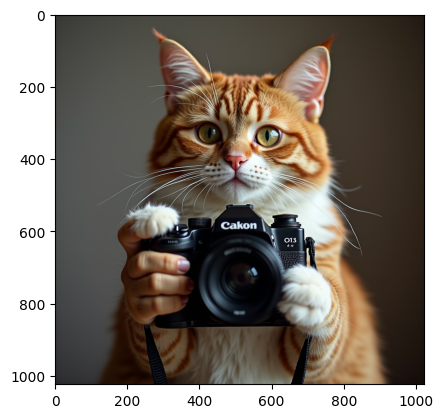

In [3]:
from rectified_flow.samplers import EulerSampler

def print_time_callback(sampler): # demo callback function
    """A callback function to print the current time t, refreshing the Jupyter Notebook output."""
    clear_output(wait=True)
    print(f"Current time: {sampler.t:.4f}")
    
my_callback = [print_time_callback]

euler_sampler = EulerSampler(
    rectified_flow=rf_func,
    callbacks=my_callback,
)

euler_sampler.sample_loop(
    X_0=X_0,
    time_grid=time_grid,
    prompt="A photo of a cat holding a camera",
    guidance_scale=3.5,
)

X_1_packed_latent = euler_sampler.trajectories[-1]
X_1_packed_latent = X_1_packed_latent.clone().to(device=device, dtype=DTYPE)
print(X_1_packed_latent.shape)

img = unpack_and_decode(pipe, X_1_packed_latent, height, width)

plt.imshow(img)

Current time: 0.9394
torch.Size([1, 4096, 64])


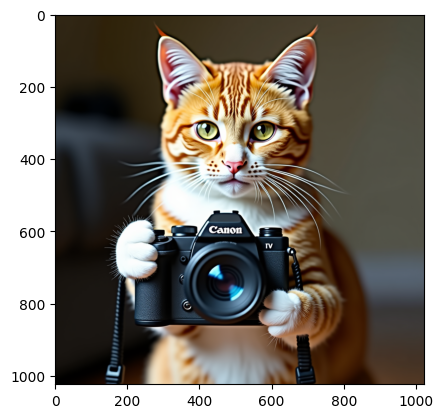

In [4]:
from rectified_flow.samplers import NoiseRefreshSampler

noise_refresh_sampler = NoiseRefreshSampler(
    rectified_flow=rf_func,
    callbacks=my_callback,
)

noise_refresh_sampler.sample_loop(
    X_0=X_0,
    time_grid=time_grid,
    prompt="A photo of a cat holding a camera",
    guidance_scale=3.5,
)

X_1_packed_latent = noise_refresh_sampler.trajectories[-1]
X_1_packed_latent = X_1_packed_latent.clone().to(device=device, dtype=DTYPE)
print(X_1_packed_latent.shape)

img = unpack_and_decode(pipe, X_1_packed_latent, height, width)

plt.imshow(img)

Current time: 0.9394
torch.Size([1, 4096, 64])


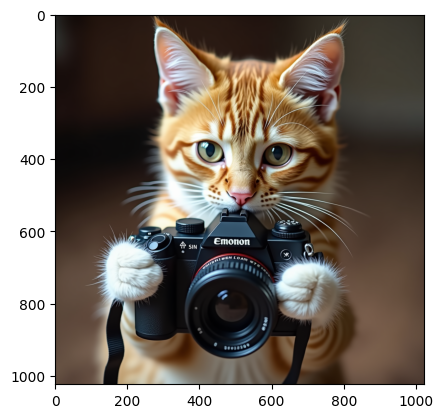

In [5]:
from rectified_flow.samplers import OverShootingSampler

overshoot_sampler = OverShootingSampler(
    rectified_flow=rf_func,
    callbacks=my_callback,
)

overshoot_sampler.sample_loop(
    X_0=X_0,
    time_grid=time_grid,
    prompt="A photo of a cat holding a camera",
    guidance_scale=3.5,
)

X_1_packed_latent = overshoot_sampler.trajectories[-1]
X_1_packed_latent = X_1_packed_latent.clone().to(device=device, dtype=DTYPE)
print(X_1_packed_latent.shape)

img = unpack_and_decode(pipe, X_1_packed_latent, height, width)

plt.imshow(img)